# Mouse 7 Analysis

This notebook loads mouse7 data, 
- plots max projection with GT and predicted masks, 
- visualizes ROI area distributions,
- compute and visualize ROIs shape 



In [1]:
# --- Imports and configuration ---
import os, sys, glob, re
import numpy as np
import h5py
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.sparse import csc_matrix

REPO_ROOT = '/gpfs/home/bizzin01/nicole/code/SUNS_nicole'
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

from suns.PreProcessing.preprocessing_functions import find_dataset

# Dataset selection
active_set = 'mouse7_new'
exp_id = 'mouse7_773'

# Paths for this dataset
from suns import config as suns_config
list_Exp_ID = suns_config.EXP_ID_SETS[active_set]
dir_video = suns_config.DATAFOLDER_SETS[active_set]
dir_parent = os.path.join(dir_video, 'output_IOU_02')
dir_net_in = os.path.join(dir_parent, 'network_input')
weights_path = os.path.join(dir_parent, 'Weights')
dir_output = os.path.join(dir_parent, 'output_masks')

print('dir_video:', dir_video)
print('dir_parent:', dir_parent)
print('dir_output:', dir_output)


importing config
dir_video: /gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new
dir_parent: /gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new/output_IOU_02
dir_output: /gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new/output_IOU_02/output_masks


In [2]:
# --- Helper functions ---
from typing import Tuple

def compute_max_projection_from_h5(h5_path: str) -> np.ndarray:
    with h5py.File(h5_path, 'r') as f:
        dset_name = find_dataset(f)
        dset = f[dset_name]
        nframes = dset.shape[0]
        max_img = np.array(dset[0], dtype=np.float32)
        for i in range(1, nframes):
            np.maximum(max_img, dset[i], out=max_img)
    vmin, vmax = float(max_img.min()), float(max_img.max())
    if vmax > vmin:
        max_img = (max_img - vmin) / (vmax - vmin)
    else:
        max_img = np.zeros_like(max_img, dtype=np.float32)
    return max_img


def load_gt_sparse_masks(gt_sparse_path: str, dims: Tuple[int, int]) -> np.ndarray:
    Lx, Ly = dims
    md = loadmat(gt_sparse_path)
    GT = csc_matrix(md['GTMasks_2'])
    pixels = Lx * Ly
    if GT.shape[0] == pixels and GT.shape[1] != pixels:
        GTp = GT
        
    elif GT.shape[1] == pixels and GT.shape[0] != pixels:
        GTp = GT.transpose()
    else:
        GTp = GT
    n_gt = GTp.shape[1]
    masks = np.zeros((n_gt, Lx, Ly), dtype=bool)
    for j in range(n_gt):
        idx = GTp.getcol(j).indices
        masks[j].ravel()[idx] = True
    return masks


def load_gt_dense_masks(gt_dense_path: str) -> np.ndarray:
    """Load dense GT masks from FinalMasks_*.mat as a (N, Ly, Lx) boolean array.
    Supports MATLAB v7.3 (HDF5) and older v7 formats. Returns empty (0,0,0) on failure.
    """
    if not os.path.exists(gt_dense_path):
        return np.zeros((0, 0, 0), dtype=bool)
    try:
        try:
            # MATLAB v7.3 (HDF5)
            with h5py.File(gt_dense_path, 'r') as f:
                if 'FinalMasks' in f:
                    m = np.array(f['FinalMasks']).astype(bool)
                else:
                    # Fallback: first non-metadata dataset
                    keys = [k for k in f.keys() if not k.startswith('_')]
                    if not keys:
                        return np.zeros((0, 0, 0), dtype=bool)
                    m = np.array(f[keys[0]]).astype(bool)
        except OSError:
            # MATLAB v7
            md = loadmat(gt_dense_path)
            if 'FinalMasks' in md:
                m = np.array(md['FinalMasks']).transpose([2, 1, 0]).astype(bool)  # -> (N, Ly, Lx)
            else:
                # Fallback: first ndarray key
                keys = [k for k in md.keys() if not k.startswith('__') and isinstance(md[k], np.ndarray)]
                if not keys:
                    return np.zeros((0, 0, 0), dtype=bool)
                mm = np.array(md[keys[0]])
                m = mm.transpose([2, 1, 0]).astype(bool) if mm.ndim == 3 else mm.astype(bool)
    except Exception as e:
        print(f"Failed to load dense GT from {gt_dense_path}: {e}")
        return np.zeros((0, 0, 0), dtype=bool)
    # Ensure stack-first
    if m.ndim == 2:
        m = m[None, ...]
    return m.astype(bool)


def load_pred_masks_from_mat(out_mat_path: str, dims: Tuple[int, int]) -> np.ndarray:
    Lx, Ly = dims
    md = loadmat(out_mat_path)
    m = md.get('Masks')
    if m is None:
        raise RuntimeError("'Masks' not found in output mat")
    # stored as (Lx, Ly, n)
    masks = np.transpose(m.astype(bool), (2, 0, 1))
    return masks


def pad_masks_top_left(masks: np.ndarray, target_dims: Tuple[int, int]) -> np.ndarray:
    """Pad masks (N, Lx_src, Ly_src) into top-left of a (N, Lx_tgt, Ly_tgt) canvas.
    If masks already match target size, returns as-is.
    """
    if masks.ndim != 3:
        raise ValueError('masks must be (N, Lx, Ly)')
    n, Lx_src, Ly_src = masks.shape
    Lx_tgt, Ly_tgt = target_dims
    if (Lx_src, Ly_src) == (Lx_tgt, Ly_tgt):
        return masks
    out = np.zeros((n, Lx_tgt, Ly_tgt), dtype=masks.dtype)
    out[:, :Lx_src, :Ly_src] = masks
    return out


def transform_masks(masks: np.ndarray, rot_k: int = 0, flip_ud: bool = False, flip_lr: bool = False) -> np.ndarray:
    """Apply 90° rotations and flips to masks array (N, Lx, Ly)."""
    if masks.ndim != 3:
        return masks
    out = masks
    rk = rot_k % 4
    if rk:
        out = np.rot90(out, k=rk, axes=(1, 2))
    if flip_ud:
        out = np.flip(out, axis=1)
    if flip_lr:
        out = np.flip(out, axis=2)
    return out


In [3]:
# --- Load data and compute max projection ---
# Prefer the preprocessed network_input for consistency with pipeline
h5_net_in = os.path.join(dir_net_in, f'{exp_id}.h5')
if os.path.exists(h5_net_in):
    with h5py.File(h5_net_in, 'r') as f:
        network_input = np.array(f['network_input'])  # (T, Lx, Ly)
    T, Lx, Ly = network_input.shape
    max_img = network_input.max(axis=0).astype(np.float32)
    vmin, vmax = float(max_img.min()), float(max_img.max())
    if vmax > vmin:
        max_img = (max_img - vmin) / (vmax - vmin)
else:
    # Fallback to raw video
    raw_h5 = os.path.join(dir_video, f'{exp_id}.h5')
    assert os.path.exists(raw_h5), f'Missing video: {raw_h5}'
    max_img = compute_max_projection_from_h5(raw_h5)
    Lx, Ly = max_img.shape

# Load masks (prefer dense FinalMasks for GT; search multiple locations for Pred)
# --- GT (dense) ---
gt_dense = os.path.join(dir_video, 'GT Masks', f'FinalMasks_{exp_id}.mat')
gt_masks = load_gt_dense_masks(gt_dense)
if gt_masks.size == 0 or gt_masks.shape[1:] != (Lx, Ly):
    # Fallback to sparse if dense missing; then pad/crop if needed
    gt_sparse = os.path.join(dir_video, 'GT Masks', f'FinalMasks_{exp_id}_sparse.mat')
    if os.path.exists(gt_sparse):
        gt_masks = load_gt_sparse_masks(gt_sparse, (Lx, Ly))
    else:
        gt_masks = np.zeros((0, Lx, Ly), dtype=bool)

# --- Predicted (search candidates and pick with most ROIs) ---
pred_candidates = [
    os.path.join(dir_output, f'Output_Masks_{exp_id}.mat'),
    # mouse7_new outputs that already exist in repo
    '/gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new/output_IOU_02/output_masks/' + f'Output_Masks_{exp_id}.mat',
]

best_pred = None
best_k = -1
best_path = None
for p in pred_candidates:
    if os.path.exists(p):
        try:
            m = load_pred_masks_from_mat(p, (Lx, Ly))
            k = m.shape[0]
            print(f"Candidate pred: {p} -> K={k}")
            if k > best_k:
                best_k = k
                best_pred = m
                best_path = p
        except Exception as e:
            print(f"Skipping {p}: {e}")

pred_masks = best_pred if best_pred is not None else np.zeros((0, Lx, Ly), dtype=bool)

n_gt = gt_masks.shape[0]
n_pred = pred_masks.shape[0]
print(f'N_GT={n_gt}, N_pred={n_pred}, shape={Lx}x{Ly}')
if best_path:
    print(f'Pred source: {best_path}')

Candidate pred: /gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new/output_IOU_02/output_masks/Output_Masks_mouse7_773.mat -> K=780
Candidate pred: /gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new/output_IOU_02/output_masks/Output_Masks_mouse7_773.mat -> K=780
N_GT=757, N_pred=780, shape=256x256
Pred source: /gpfs/home/bizzin01/nicole/code/SUNS_nicole/demo/mouse7_new/output_IOU_02/output_masks/Output_Masks_mouse7_773.mat


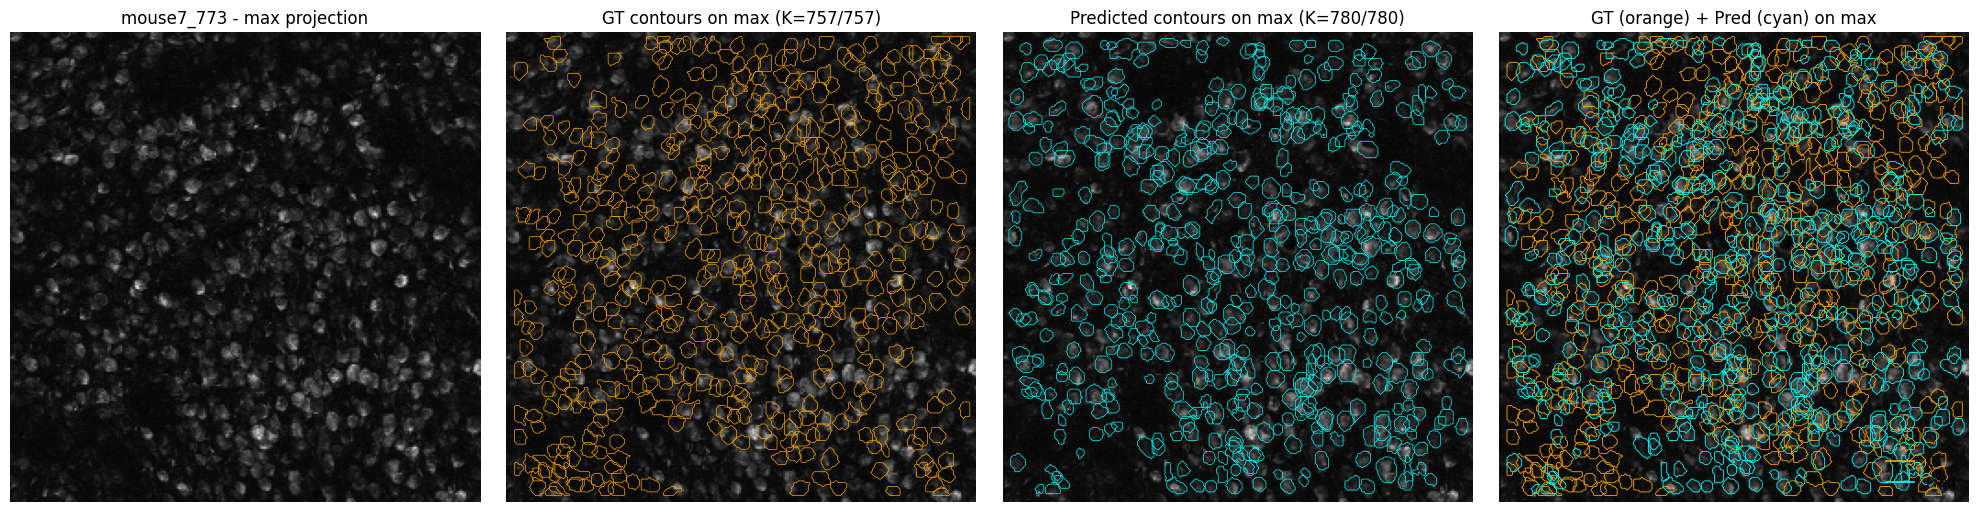

In [ ]:
# --- Visualization alignment parameters ---
# Rotate GT (and Pred if needed) by 90-degree steps to match network_input orientation
GT_ROT_K = 1 # values: 0, 1, 2, 3 (counter-clockwise 90° steps)
GT_FLIPUD = False
GT_FLIPLR = False

PRED_ROT_K = 0
PRED_FLIPUD = False
PRED_FLIPLR = False

# Auto-align GT to Pred by maximizing occupancy IoU (optional)
AUTO_ALIGN_GT = True
if AUTO_ALIGN_GT and gt_masks.size and pred_masks.size:
    occ_gt = gt_masks.any(axis=0)   # (H,W)
    occ_pr = pred_masks.any(axis=0) # (H,W)

    def apply_2d_transform(img2d, rot_k, flip_ud, flip_lr):
        out = img2d
        rk = rot_k % 4
        if rk:
            out = np.rot90(out, k=rk)
        if flip_ud:
            out = np.flip(out, axis=0)
        if flip_lr:
            out = np.flip(out, axis=1)
        return out

    best = ( -1.0, GT_ROT_K, GT_FLIPUD, GT_FLIPLR )
    for rk in range(4):
        for fud in (False, True):
            for flr in (False, True):
                t = apply_2d_transform(occ_gt, rk, fud, flr)
                inter = np.logical_and(t, occ_pr).sum()
                uni   = np.logical_or(t, occ_pr).sum()
                score = float(inter) / float(uni) if uni > 0 else 0.0
                if score > best[0]:
                    best = (score, rk, fud, flr)
    GT_ROT_K, GT_FLIPUD, GT_FLIPLR = best[1], best[2], best[3]
    print(f"Auto-aligned GT → rot={GT_ROT_K}, flip_ud={GT_FLIPUD}, flip_lr={GT_FLIPLR}, IoU={best[0]:.3f}")

# Prepare rotated/flipped stacks just for visualization
gt_masks_vis = transform_masks(gt_masks, rot_k=GT_ROT_K, flip_ud=GT_FLIPUD, flip_lr=GT_FLIPLR) if gt_masks.size else gt_masks
pred_masks_vis = transform_masks(pred_masks, rot_k=PRED_ROT_K, flip_ud=PRED_FLIPUD, flip_lr=PRED_FLIPLR) if pred_masks.size else pred_masks
n_gt_vis = gt_masks_vis.shape[0]
n_pred_vis = pred_masks_vis.shape[0]

# --- Plot: 4 subplots in one row (max, GT-on-max, Pred-on-max, Both-on-max) ---
from matplotlib.lines import Line2D
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

# 1) max projection only
axs[0].imshow(max_img, cmap='gray', origin='lower')
axs[0].set_title(f'{exp_id} - max projection')
axs[0].axis('off')

# 2) GT contours on the same max projection
axs[1].imshow(max_img, cmap='gray', origin='lower')
if n_gt_vis > 0:
    Kgt = min(n_gt_vis, 500)
    for i in range(Kgt):
        if gt_masks_vis[i].any():
            axs[1].contour(gt_masks_vis[i].astype(float), levels=[0.5], colors='orange', linewidths=0.5, origin='lower')
axs[1].set_title(f'GT contours on max (K={min(n_gt_vis,n_gt_vis)}/{n_gt_vis})')
axs[1].axis('off')

# 3) Predicted contours on the same max projection
axs[2].imshow(max_img, cmap='gray', origin='lower')
if n_pred_vis > 0:
    Kpred = min(n_pred_vis, 500)
    for i in range(Kpred):
        if pred_masks_vis[i].any():
            axs[2].contour(pred_masks_vis[i].astype(float), levels=[0.5], colors='cyan', linewidths=0.5, origin='lower')
axs[2].set_title(f'Predicted contours on max (K={min(n_pred_vis,n_pred_vis)}/{n_pred_vis})')
axs[2].axis('off')

# 4) Both GT and Pred contours on the same max projection
axs[3].imshow(max_img, cmap='gray', origin='lower')
if n_gt_vis > 0:
    Kgt = min(n_gt_vis, 500)
    for i in range(Kgt):
        if gt_masks_vis[i].any():
            axs[3].contour(gt_masks_vis[i].astype(float), levels=[0.5], colors='orange', linewidths=0.6, origin='lower')
if n_pred_vis > 0:
    Kpred = min(n_pred_vis, 500)
    for i in range(Kpred):
        if pred_masks_vis[i].any():
            axs[3].contour(pred_masks_vis[i].astype(float), levels=[0.5], colors='cyan', linewidths=0.6, origin='lower')
axs[3].set_title('GT (orange) + Pred (cyan) on max')
axs[3].axis('off')

# Optional legend (proxy lines)
legend_elems = [
    Line2D([0],[0], color='orange', lw=1.2, label='GT'),
    Line2D([0],[0], color='cyan',   lw=1.2, label='Pred')
]
axs[3].legend(handles=legend_elems, frameon=False, loc='lower right')

plt.tight_layout(); plt.show()


Matched pairs (IoU≥0.0): 757
IoU percentiles: [0.         0.         0.18571429 0.36046511 0.55905882]


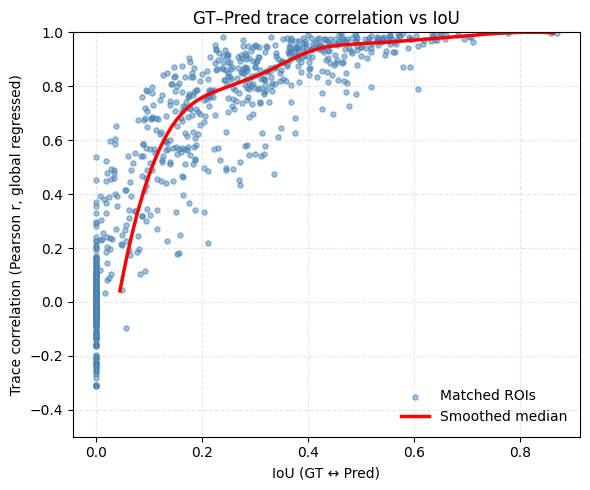

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

# -------- helpers --------
def ensure_stack_first(masks):
    # Accept (N,Y,X) or (Y,X,N); return (N,Y,X)
    if masks.ndim != 3:
        raise ValueError("masks must be 3D")
    if masks.shape[0] in (masks.shape[1], masks.shape[2]) and masks.shape[0] != masks.shape[-1]:
        # likely (Y,X,N)
        return np.moveaxis(masks, -1, 0)
    return masks

def pairwise_iou(A_bool, B_bool):
    A_bool = ensure_stack_first(A_bool).astype(bool)
    B_bool = ensure_stack_first(B_bool).astype(bool)
    Na, H, W = A_bool.shape
    Nb = B_bool.shape[0]
    A2 = A_bool.reshape(Na, -1).astype(np.uint8)
    B2 = B_bool.reshape(Nb, -1).astype(np.uint8)
    inter = A2 @ B2.T                           # (Na,Nb) pixel intersections
    a_sum = A2.sum(axis=1, keepdims=True)       # (Na,1)
    b_sum = B2.sum(axis=1, keepdims=True).T     # (1,Nb)
    union = a_sum + b_sum - inter
    I = np.zeros_like(inter, dtype=np.float32)
    valid = union > 0
    I[valid] = inter[valid] / union[valid]
    return I

def extract_mean_traces(video_T_y_x, masks_bool):
    masks_bool = ensure_stack_first(masks_bool).astype(bool)
    T = video_T_y_x.shape[0]
    traces = np.zeros((masks_bool.shape[0], T), dtype=np.float32)
    for i, m in enumerate(masks_bool):
        if m.any():
            traces[i] = video_T_y_x[:, m].mean(axis=1)
    return traces

def zscore_rows(X, eps=1e-8):
    mu = X.mean(axis=1, keepdims=True)
    sd = X.std(axis=1, keepdims=True) + eps
    return (X - mu) / sd

def regress_out_global(traces, global_trace):
    # remove projection onto the global signal: r = t - ((t·g)/(g·g)) g
    g = (global_trace - global_trace.mean()) / (global_trace.std() + 1e-8)
    gg = np.dot(g, g) + 1e-8
    proj = (traces @ g[None, :].T) / gg           # (N,1)
    return traces - proj * g[None, :]

# -------- compute IoU & match with threshold --------
IoU = pairwise_iou(gt_masks, pred_masks)

tau = 0.0 # <-- set acceptance threshold here
cost = 1.0 - IoU
cost[IoU < tau] = 1e6                            # forbid low-overlap pairs

row_ind, col_ind = linear_sum_assignment(cost)
matched_iou = IoU[row_ind, col_ind]
keep = matched_iou >= tau
row_ind, col_ind, matched_iou = row_ind[keep], col_ind[keep], matched_iou[keep]

print(f"Matched pairs (IoU≥{tau}): {len(matched_iou)}")
print("IoU percentiles:", np.percentile(matched_iou, [5,25,50,75,95]))

# -------- traces, z-score, and global/neuropil removal --------
# network_input : (T,Y,X) – same movie used for both GT and Pred
gt_tr  = extract_mean_traces(network_input, gt_masks)   # (N_gt, T)
pr_tr  = extract_mean_traces(network_input, pred_masks) # (N_pr, T)

# remove FOV global signal (crude neuropil/global correction)
gtrace = network_input.mean(axis=(1,2)).astype(np.float32)  # (T,)
gt_tr = regress_out_global(gt_tr, gtrace)
pr_tr = regress_out_global(pr_tr, gtrace)

# z-score rows
gt_z = zscore_rows(gt_tr)
pr_z = zscore_rows(pr_tr)

# -------- correlations per matched pair --------
corrs = np.empty_like(matched_iou, dtype=np.float32)
for k, (gi, pi) in enumerate(zip(row_ind, col_ind)):
    t1, t2 = gt_z[gi], pr_z[pi]
    T_use = min(t1.size, t2.size)
    r = np.corrcoef(t1[:T_use], t2[:T_use])[0, 1]
    corrs[k] = r

# -------- plot: scatter + binned trend --------
# -------- plot: scatter + smooth red trend line --------
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
import numpy as np

x, y = matched_iou, corrs

plt.figure(figsize=(6,5))
plt.scatter(x, y, s=14, alpha=0.5, color='steelblue', label='Matched ROIs')

# compute median per bin (for a stable baseline)
bins = np.linspace(tau, 1.0, 12)
centers = 0.5*(bins[:-1] + bins[1:])
med = [np.median(y[(x>=bins[i]) & (x<bins[i+1])]) if np.any((x>=bins[i]) & (x<bins[i+1])) else np.nan
       for i in range(len(bins)-1)]
centers, med = np.array(centers), np.array(med)

# smooth with a spline (cubic)
mask = np.isfinite(med)
if np.sum(mask) >= 4:
    spline = make_interp_spline(centers[mask], med[mask], k=3)
    x_smooth = np.linspace(centers[mask].min(), centers[mask].max(), 300)
    y_smooth = spline(x_smooth)
    plt.plot(x_smooth, y_smooth, color='red', lw=2.5, label='Smoothed median')
else:
    plt.plot(centers, med, color='red', lw=2.5, label='Median (unsmoothed)') # change color to red

plt.xlabel('IoU (GT ↔ Pred)')
plt.ylabel('Trace correlation (Pearson r, global regressed)')
#plt.title('GT–Pred trace correlation vs IoU (τ = %.2f)' % tau)
plt.title('GT–Pred trace correlation vs IoU')
plt.grid(True, linestyle='--', alpha=0.3)
plt.ylim(-0.5, 1.0)
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

# The plot compares spatial overlap (IoU) with temporal similarity 
# (correlation of calcium traces) between matched ROIs from  
# two segmentation methods.
# Each blue dot is one matched neuron pair (GT - Pred).


In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linear_sum_assignment

def show_pairs_by_iou_bins(
    video_TYX, gt_masks, pred_masks,
    bins=[(0.10,0.30), (0.45,0.55), (0.75,0.90)],  # LOW, MID, HIGH
    n_per_bin=3, half=28, iou_min_keep=0.05,
    global_regress=True, zscore_tr=True
):
    """
    For each IoU bin, show n_per_bin matched pairs:
      left: max-projection patch with GT (orange) & Pred (cyan) contours
      right: overlapped traces (GT vs Pred)
    """
    # --- prepare + match ---
    gt_masks  = ensure_stack_first(gt_masks).astype(bool)
    pred_masks= ensure_stack_first(pred_masks).astype(bool)
    IoU = pairwise_iou(gt_masks, pred_masks)

    cost = 1.0 - IoU
    cost[IoU < iou_min_keep] = 1e6
    gi, pi = linear_sum_assignment(cost)
    m_iou  = IoU[gi, pi]
    keep   = m_iou >= iou_min_keep
    gi, pi, m_iou = gi[keep], pi[keep], m_iou[keep]

    if m_iou.size == 0:
        raise RuntimeError(f"No matches with IoU ≥ {iou_min_keep}")

    # prep figure: rows = n_per_bin, columns = 2 * (#bins)
    B = len(bins)
    rows = n_per_bin
    fig = plt.figure(figsize=(4.2*2*B, 2.8*rows))
    maxproj = video_TYX.max(axis=0)
    vmin, vmax = np.percentile(maxproj, (1,99))
    g = video_TYX.mean(axis=(1,2)) if global_regress else None

    def pick_indices_for_bin(lo, hi, k):
        idx = np.where((m_iou >= lo) & (m_iou < hi))[0]
        if idx.size == 0:
            # fallback: take closest IoUs to the bin center
            c = 0.5*(lo+hi)
            idx = np.argsort(np.abs(m_iou - c))[:k]
        else:
            # choose the k IoUs closest to the bin center within the bin
            c = 0.5*(lo+hi)
            idx = idx[np.argsort(np.abs(m_iou[idx] - c))[:k]]
        return idx

    # column headers
    for b,(lo,hi) in enumerate(bins):
        x = (2*b+1)/(2*B)
        fig.text(x, 0.99, f"IoU bin: [{lo:.2f}, {hi:.2f})", ha='center', va='top', fontsize=12)

    # fill grid
    for b,(lo,hi) in enumerate(bins):
        idxs = pick_indices_for_bin(lo, hi, n_per_bin)
        for r,row_i in enumerate(idxs):
            gidx, pidx, iou_val = int(gi[row_i]), int(pi[row_i]), float(m_iou[row_i])

            mgt = gt_masks[gidx]; mpr = pred_masks[pidx]
            # center crop around avg COM
            y1,x1 = center_of_mass(mgt); y2,x2 = center_of_mass(mpr)
            cy,cx = (y1+y2)/2, (x1+x2)/2
            patch = crop(maxproj, cy, cx, half=half)
            mgt_c = crop(mgt.astype(float), cy, cx, half=half) > 0.5
            mpr_c = crop(mpr.astype(float), cy, cx, half=half) > 0.5

            # traces
            t_gt = roi_trace(video_TYX, mgt)
            t_pr = roi_trace(video_TYX, mpr)
            if global_regress:
                t_gt = regress_out_global(t_gt, g)
                t_pr = regress_out_global(t_pr, g)
            if zscore_tr:
                t_gt = zscore(t_gt); t_pr = zscore(t_pr)
            r_val = float(np.corrcoef(t_gt, t_pr)[0,1])

            # axes positions
            axL = plt.subplot(rows, 2*B, r*(2*B) + 2*b + 1)
            axR = plt.subplot(rows, 2*B, r*(2*B) + 2*b + 2)

            # image + contours
            axL.imshow(patch, cmap='gray', vmin=vmin, vmax=vmax)
            axL.contour(mgt_c, levels=[0.5], colors='#F39C12', linewidths=1.6)  # GT orange
            axL.contour(mpr_c, levels=[0.5], colors='#17A2B8', linewidths=1.6)  # Pred cyan
            axL.set_title(f"GT #{gidx} vs Pred #{pidx}\nIoU={iou_val:.2f}, r={r_val:.2f}", fontsize=10)
            axL.axis('off')

            # overlapped traces
            axR.plot(t_gt, lw=1.6, color='#F39C12', label='GT')
            axR.plot(t_pr, lw=1.6, color='#17A2B8', alpha=0.9, label='Pred')
            axR.grid(True, ls='--', alpha=0.3)
            if r==0 and b==B-1:  # put legend once
                axR.legend(frameon=False, loc='upper right')
            axR.set_xlabel("Frame")
            axR.set_ylabel("Fluorescence (z)" if zscore_tr else "Fluorescence (a.u.)")

    plt.tight_layout(rect=[0,0,1,0.965])
    plt.show()


In [28]:
show_pairs_by_iou_bins(
    video_TYX=network_input,
    gt_masks=gt_masks,
    pred_masks=pred_masks,
    bins=[(0.10,0.30), (0.45,0.55), (0.75,0.90)],  # low, mid, high
    n_per_bin=2,    # how many examples per bin (rows)
    half=30,
    global_regress=True,
    zscore_tr=True
)


/gpfs/home/bizzin01/.cache/cursor-remote-tmp/ipykernel_3482591/4187999933.py:100: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(rect=[0,0,1,0.965])


ValueError: Image size of 1951x66905 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 2520x560 with 12 Axes>

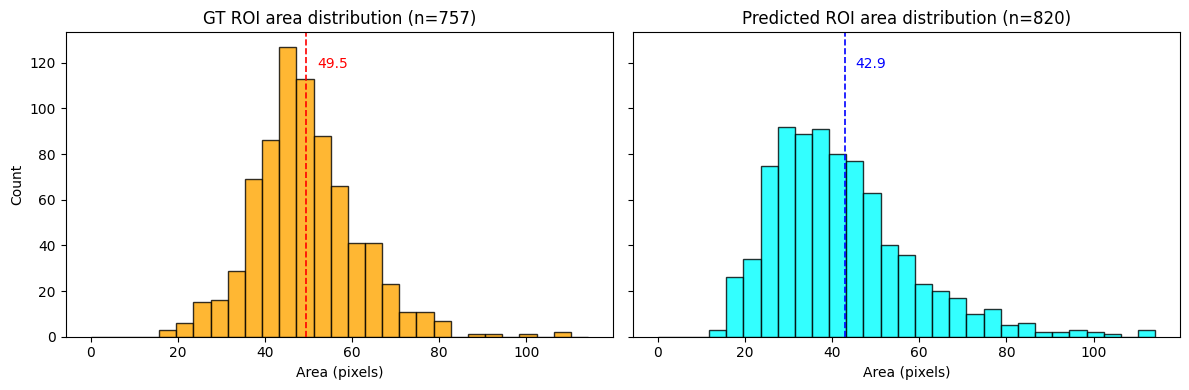

In [19]:
# --- ROI Area distributions (bar graphs + mean markers) ---
# Compute per-ROI areas in pixels
areas_gt = gt_masks.reshape(gt_masks.shape[0], -1).sum(axis=1) if gt_masks.size else np.array([])
areas_pr = pred_masks.reshape(pred_masks.shape[0], -1).sum(axis=1) if pred_masks.size else np.array([])

# Use common bins for fair comparison
all_areas = np.concatenate([areas_gt, areas_pr]) if areas_gt.size and areas_pr.size else (areas_gt if areas_gt.size else areas_pr)
if all_areas.size:
    hi = np.percentile(all_areas, 99.5)
    bins = np.linspace(0, hi, 30)
else:
    bins = 30

fig, ax = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

# GT bar graph + mean
ax[0].hist(areas_gt, bins=bins, color='orange', alpha=0.8, edgecolor='k')
ax[0].set_title(f'GT ROI area distribution (n={len(areas_gt)})')
ax[0].set_xlabel('Area (pixels)')
ax[0].set_ylabel('Count')
if areas_gt.size:
    mean_gt = float(np.mean(areas_gt))
    ax[0].axvline(mean_gt, color='red', linestyle='--', linewidth=1.2)
    ymax = ax[0].get_ylim()[1]
    xmin, xmax = ax[0].get_xlim()
    offset = 0.02 * (xmax - xmin)
    ax[0].text(min(mean_gt + offset, xmax), 0.92*ymax, f'{mean_gt:.1f}', color='red', ha='left', va='top')

# Pred bar graph + mean
ax[1].hist(areas_pr, bins=bins, color='cyan', alpha=0.8, edgecolor='k')
ax[1].set_title(f'Predicted ROI area distribution (n={len(areas_pr)})')
ax[1].set_xlabel('Area (pixels)')
if areas_pr.size:
    mean_pr = float(np.mean(areas_pr))
    ax[1].axvline(mean_pr, color='blue', linestyle='--', linewidth=1.2)
    ymax = ax[1].get_ylim()[1]
    xmin, xmax = ax[1].get_xlim()
    offset = 0.02 * (xmax - xmin)
    ax[1].text(min(mean_pr + offset, xmax), 0.92*ymax, f'{mean_pr:.1f}', color='blue', ha='left', va='top')

plt.tight_layout(); plt.show()


GT  mean circularity:  0.753 ± 0.119
Pred mean circularity: 0.752 ± 0.145


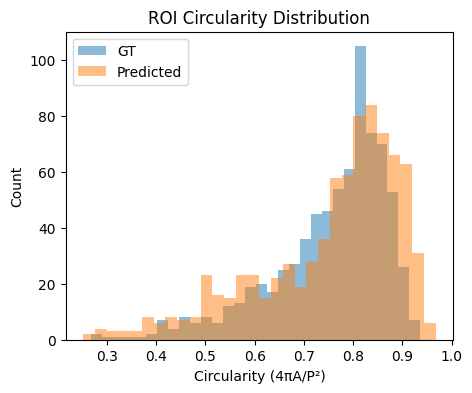

In [ ]:
from skimage import measure

def compute_circularity(masks):
    """
    Compute circularity for each binary mask in the stack.
    Circularity = 4π * Area / (Perimeter²)
    Returns list of circularity values and perimeters.
    """
    circularities, perimeters, areas = [], [], []

    for i, mask in enumerate(masks):
        mask = mask.astype(bool)
        if not np.any(mask):
            circularities.append(np.nan)
            perimeters.append(0)
            areas.append(0)
            continue

        # Area = number of pixels
        area = np.sum(mask)
        areas.append(area)

        # Extract contours and measure perimeter in pixels
        contours = measure.find_contours(mask, 0.5)
        perim = 0.0
        for c in contours:
            diff = np.diff(c, axis=0)
            perim += np.sum(np.sqrt((diff ** 2).sum(axis=1)))
        perimeters.append(perim)

        # Circularity formula (avoid division by 0)
        circ = 4 * np.pi * area / (perim ** 2 + 1e-8)
        circularities.append(circ)

    return np.array(circularities), np.array(perimeters), np.array(areas)


# ---- Compute shape metrics for both GT and predictions ----
circ_gt, perim_gt, area_gt = compute_circularity(gt_masks)
circ_pr, perim_pr, area_pr = compute_circularity(pred_masks)

print(f"GT  mean circularity:  {np.nanmean(circ_gt):.3f} ± {np.nanstd(circ_gt):.3f}")
print(f"Pred mean circularity: {np.nanmean(circ_pr):.3f} ± {np.nanstd(circ_pr):.3f}")

# ---- Optional visualization ----
plt.figure(figsize=(5,4))
plt.hist(circ_gt, bins=30, alpha=0.5, label='GT')
plt.hist(circ_pr, bins=30, alpha=0.5, label='Predicted')
plt.xlabel('Circularity (4πA/P²)')
plt.ylabel('Count')
plt.legend()
plt.title('ROI Circularity Distribution')
plt.show()

# Each bar shows how many ROIs have a given circularity value. circularity= 4πA/P²: 1.0 means a perfect circle; lower values mean more elongated/irregular shapes.
# GT = 0.753, Pred = 0.841 mean the predicted ROIs are, on average, rounder and more uniform than the GT. The broader GT histogram indicates more shape 
# variety (irregular/merged cells).
# Any values slightly above 1 are due to pixel-grid/perimeter approximation; they’re harmless. If you want tighter estimates, compute perimeter with a sub‑pixel
#  method (e.g., skimage.measure.perimeter) or lightly smooth masks before measuring.

GT intra-set overlap (any pixel overlap): 87.5% of ROIs
Pred intra-set overlap (any pixel overlap): 82.3% of ROIs
GT intra-set overlap (IoU>0.1): 34.5%
Pred intra-set overlap (IoU>0.1): 56.6%
Fraction of GT neurons covered by Pred (IoU≥0.5): 45.6%
Fraction of Pred neurons supported by GT (IoU≥0.5): 43.0%


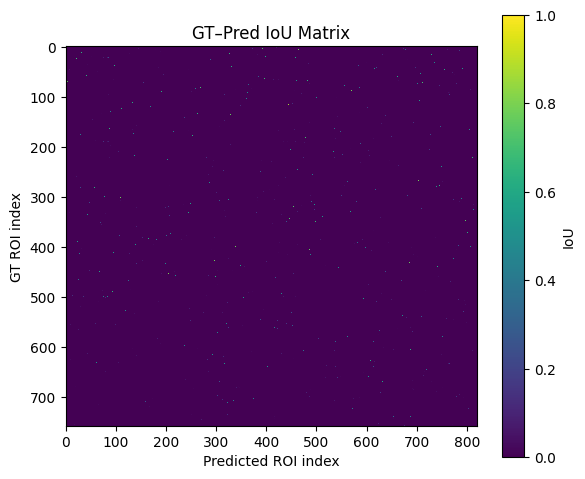

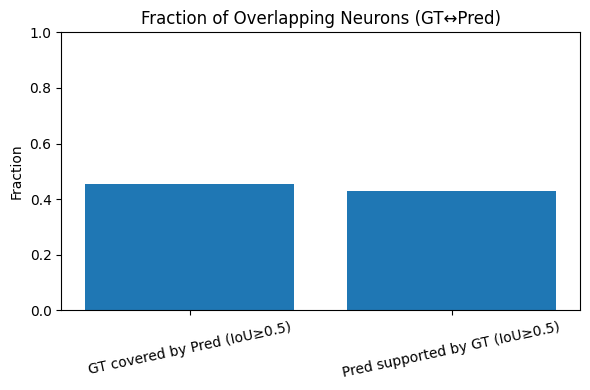

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Overlap utilities
# ----------------------------
def pairwise_iou(stackA, stackB):
    """
    Memory-safe IoU:
    stackA: (Na, H, W) bool
    stackB: (Nb, H, W) bool
    returns IoU matrix (Na x Nb)
    """
    Na, H, W = stackA.shape
    Nb = stackB.shape[0]
    A = stackA.reshape(Na, -1).astype(np.uint8)
    B = stackB.reshape(Nb, -1).astype(np.uint8)

    # intersections via dot product
    inter = (A.astype(np.int32) @ B.astype(np.int32).T)  # (Na, Nb)
    areaA = A.sum(axis=1).astype(np.int32)[:, None]      # (Na, 1)
    areaB = B.sum(axis=1).astype(np.int32)[None, :]      # (1, Nb)
    union = areaA + areaB - inter
    iou = np.zeros((Na, Nb), dtype=np.float32)
    valid = union > 0
    iou[valid] = inter[valid] / union[valid]
    return iou

def within_set_overlap_fraction(stack, thresh=0.0, ratio='iou'):
    """
    Fraction of ROIs that overlap with at least one other ROI in the SAME set.
    Uses matmul for intersections (no 3-D arrays).
    """
    N = stack.shape[0]
    if N <= 1:
        return 0.0, np.zeros((N, N), dtype=np.float32)

    M = stack.reshape(N, -1).astype(np.uint8)
    areas = M.sum(axis=1).astype(np.int32)                  # (N,)
    inter = (M.astype(np.int32) @ M.astype(np.int32).T)     # (N, N)

    if ratio == 'iou' or ratio == 'union':
        union = areas[:, None] + areas[None, :] - inter     # (N, N)
        with np.errstate(divide='ignore', invalid='ignore'):
            mat = np.where(union > 0, inter / union, 0.0).astype(np.float32)
    elif ratio == 'min':
        amin = np.minimum(areas[:, None], areas[None, :])
        with np.errstate(divide='ignore', invalid='ignore'):
            mat = np.where(amin > 0, inter / amin, 0.0).astype(np.float32)
    else:
        raise ValueError("ratio must be 'iou', 'min', or 'union'.")

    np.fill_diagonal(mat, 0.0)  # ignore self
    has_overlap = (mat > thresh).any(axis=1)
    frac = has_overlap.mean() if N > 0 else 0.0
    return float(frac), mat


def between_sets_overlap_fractions(gt, pr, iou_thresh=0.5):
    """
    Fractions across sets:
      - fraction of GT ROIs that have at least one predicted ROI with IoU >= thresh
      - fraction of Pred ROIs that have at least one GT ROI with IoU >= thresh
      - also returns helpful summaries
    """
    if gt.shape[0] == 0 or pr.shape[0] == 0:
        return {
            "iou_matrix": np.zeros((gt.shape[0], pr.shape[0]), dtype=np.float32),
            "frac_gt_covered": 0.0,
            "frac_pred_supported": 0.0,
            "gt_max_iou": np.zeros(gt.shape[0], dtype=np.float32),
            "pr_max_iou": np.zeros(pr.shape[0], dtype=np.float32),
        }

    iou = pairwise_iou(gt, pr)
    gt_max = iou.max(axis=1) if iou.size else np.array([])
    pr_max = iou.max(axis=0) if iou.size else np.array([])
    frac_gt = (gt_max >= iou_thresh).mean() if gt_max.size else 0.0
    frac_pr = (pr_max >= iou_thresh).mean() if pr_max.size else 0.0

    return {
        "iou_matrix": iou,
        "frac_gt_covered": float(frac_gt),
        "frac_pred_supported": float(frac_pr),
        "gt_max_iou": gt_max,
        "pr_max_iou": pr_max,
    }

# ----------------------------
# Run the analyses
# ----------------------------
# Intra-set (collisions within GT and within Pred)
frac_gt_overlap, gt_overlap_mat = within_set_overlap_fraction(gt_masks, thresh=0.0, ratio='iou')
frac_pr_overlap, pr_overlap_mat = within_set_overlap_fraction(pred_masks, thresh=0.0, ratio='iou')

print(f"GT intra-set overlap (any pixel overlap): {100*frac_gt_overlap:.1f}% of ROIs")
print(f"Pred intra-set overlap (any pixel overlap): {100*frac_pr_overlap:.1f}% of ROIs")

# You can tighten the definition (e.g., IoU>0.1 to ignore tiny touches)
frac_gt_overlap_iou01, _ = within_set_overlap_fraction(gt_masks, thresh=0.1, ratio='iou')
frac_pr_overlap_iou01, _ = within_set_overlap_fraction(pred_masks, thresh=0.1, ratio='iou')
print(f"GT intra-set overlap (IoU>0.1): {100*frac_gt_overlap_iou01:.1f}%")
print(f"Pred intra-set overlap (IoU>0.1): {100*frac_pr_overlap_iou01:.1f}%")

# Inter-set (coverage between GT and Pred)
ov = between_sets_overlap_fractions(gt_masks, pred_masks, iou_thresh=0.5)
print(f"Fraction of GT neurons covered by Pred (IoU≥0.5): {100*ov['frac_gt_covered']:.1f}%")
print(f"Fraction of Pred neurons supported by GT (IoU≥0.5): {100*ov['frac_pred_supported']:.1f}%")

# ----------------------------
# Quick visuals (optional)
# ----------------------------
# IoU heatmap GT x Pred
if ov["iou_matrix"].size:
    plt.figure(figsize=(6,5))
    plt.imshow(ov["iou_matrix"], vmin=0, vmax=1, interpolation='nearest')
    plt.colorbar(label='IoU')
    plt.xlabel('Predicted ROI index')
    plt.ylabel('GT ROI index')
    plt.title('GT–Pred IoU Matrix')
    plt.tight_layout()
    plt.show()

# Bars summarizing "fraction overlapping neurons"
labels = ['GT covered by Pred (IoU≥0.5)', 'Pred supported by GT (IoU≥0.5)']
vals = [ov["frac_gt_covered"], ov["frac_pred_supported"]]
plt.figure(figsize=(6,4))
plt.bar(labels, vals)
plt.ylim(0,1)
plt.ylabel('Fraction')
plt.title('Fraction of Overlapping Neurons (GT↔Pred)')
plt.xticks(rotation=12)
plt.tight_layout()
plt.show()


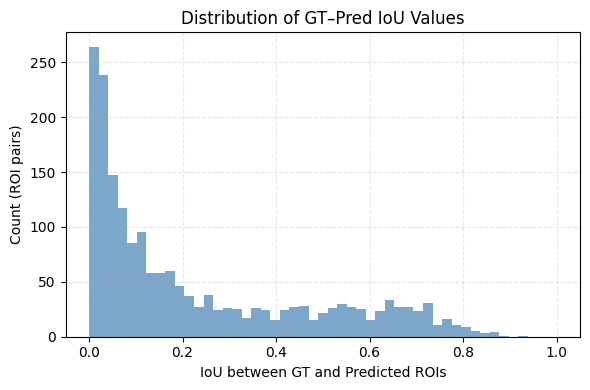

Mean IoU: 0.231 ± 0.238
Median IoU: 0.122
Fraction IoU ≥ 0.1: 55.4%
Fraction IoU ≥ 0.3: 30.8%
Fraction IoU ≥ 0.5: 19.0%


In [25]:
# --------------------------------------
# Distribution of GT–Pred IoU values
# --------------------------------------

iou_vals = ov["iou_matrix"].ravel()         # Flatten matrix to 1D
iou_vals = iou_vals[iou_vals > 0]           # Keep only positive overlaps

plt.figure(figsize=(6,4))
plt.hist(iou_vals, bins=np.linspace(0,1,50), color='steelblue', alpha=0.7)
plt.xlabel("IoU between GT and Predicted ROIs")
plt.ylabel("Count (ROI pairs)")
plt.title("Distribution of GT–Pred IoU Values")
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: print statistics
if iou_vals.size > 0:
    print(f"Mean IoU: {iou_vals.mean():.3f} ± {iou_vals.std():.3f}")
    print(f"Median IoU: {np.median(iou_vals):.3f}")
    print(f"Fraction IoU ≥ 0.1: {(iou_vals >= 0.1).mean()*100:.1f}%")
    print(f"Fraction IoU ≥ 0.3: {(iou_vals >= 0.3).mean()*100:.1f}%")
    print(f"Fraction IoU ≥ 0.5: {(iou_vals >= 0.5).mean()*100:.1f}%")
else:
    print("No overlapping pairs found.")

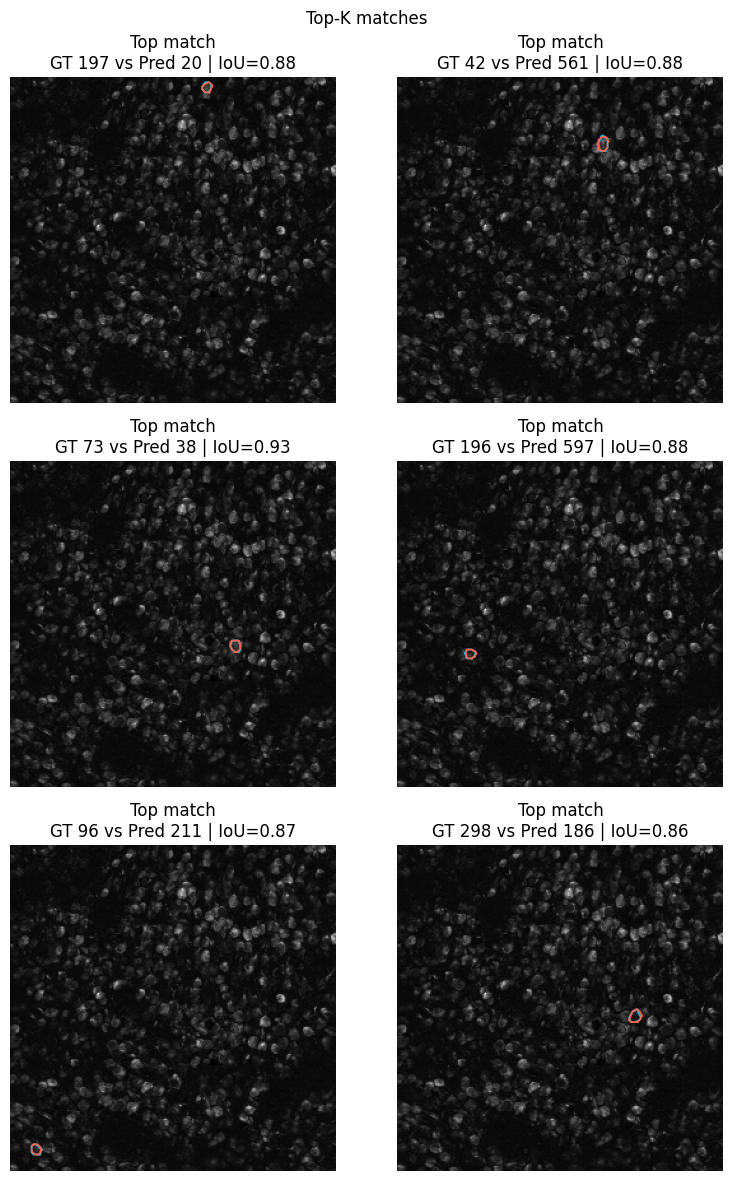

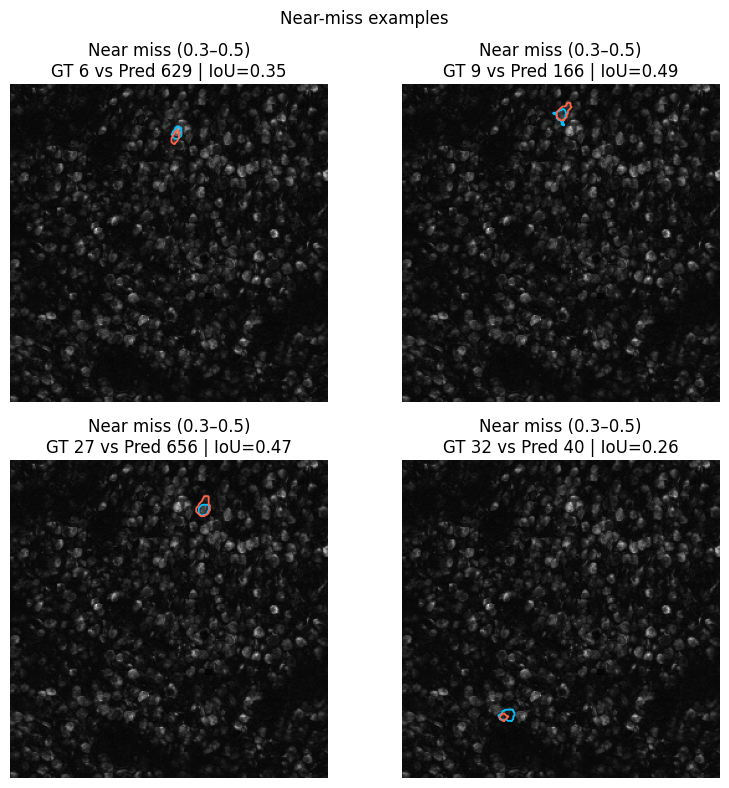

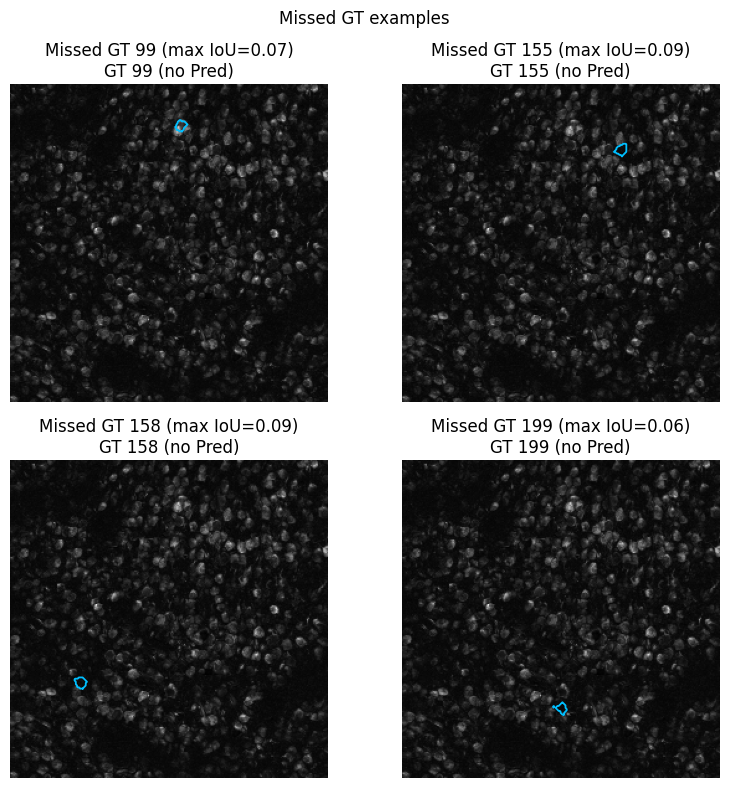

In [26]:
from skimage import measure


def draw_contours_on_image(img, masks, indices, color, lw=1.0, ax=None):
    H, W = img.shape
    ax = ax if ax is not None else plt.gca()
    for idx in indices:
        m = masks[idx].astype(bool)
        for c in measure.find_contours(m, 0.5):
            x, y = c[:,1], c[:,0]
            ax.plot(x, y, color=color, lw=lw)


def show_pair_overlay(ax, gt_idx, pr_idx=None, title=''):
    ax.imshow(max_img, cmap='gray', vmin=0, vmax=1)
    draw_contours_on_image(max_img, gt_masks, [gt_idx], color='deepskyblue', lw=1.3, ax=ax)
    if pr_idx is not None:
        draw_contours_on_image(max_img, pred_masks, [pr_idx], color='tomato', lw=1.3, ax=ax)
        iou_val = ov["iou_matrix"][gt_idx, pr_idx]
        ttl = f'{title}\nGT {gt_idx} vs Pred {pr_idx} | IoU={iou_val:.2f}'
    else:
        ttl = f'{title}\nGT {gt_idx} (no Pred)'
    ax.set_title(ttl)
    ax.axis('off')


def _grid_dims(n, max_rows=3):
    if n <= 0:
        return 1, 1
    ncols = int(np.ceil(n / max_rows))
    nrows = int(np.ceil(n / ncols))
    return nrows, ncols


def _plot_pairs_grid(pairs, suptitle):
    n = len(pairs)
    if n == 0:
        return
    nrows, ncols = _grid_dims(n, max_rows=3)
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = np.array(axes).reshape(-1)
    for ax, (g, p, t) in zip(axes, pairs):
        show_pair_overlay(ax, int(g), (int(p) if p is not None else None), title=t)
    for ax in axes[len(pairs):]:
        ax.axis('off')
    fig.suptitle(suptitle, y=0.98)
    plt.tight_layout()
    plt.show()


I = ov["iou_matrix"]
if I.size:
    # --- Top-K best matches ---
    K = 6
    flat = I.ravel()
    top_idx = np.argpartition(-flat, kth=min(K, flat.size-1))[:K]
    gt_top, pr_top = np.unravel_index(top_idx, I.shape)
    top_pairs = [(g, p, 'Top match') for g, p in zip(gt_top, pr_top)]
    _plot_pairs_grid(top_pairs, 'Top-K matches')

    # --- Near-miss examples: best IoU in [0.3, 0.5) ---
    g_best = I.max(axis=1)
    cand = np.where((g_best >= 0.20) & (g_best < 0.50))[0]
    near_pairs = []
    for g in cand[:4]:
        p = int(I[g].argmax())
        near_pairs.append((int(g), p, 'Near miss (0.3–0.5)'))
    _plot_pairs_grid(near_pairs, 'Near-miss examples')

    # --- Missed GT examples: best IoU < 0.1 ---
    missed = np.where(I.max(axis=1) < 0.10)[0]
    miss_pairs = [(int(g), None, f'Missed GT {int(g)} (max IoU={I[g].max():.2f})') for g in missed[:4]]
    _plot_pairs_grid(miss_pairs, 'Missed GT examples')


In [27]:
def pairwise_max_overlap(gt_masks, pred_masks):
    """
    Computes pairwise overlap between GT and Predicted masks using
    max(intersection/area_gt, intersection/area_pred).
    Returns:
        overlap_matrix: (N_gt x N_pred) float array in [0,1]
    """
    N_gt, H, W = gt_masks.shape
    N_pr = pred_masks.shape[0]
    A = gt_masks.reshape(N_gt, -1).astype(np.uint8)
    B = pred_masks.reshape(N_pr, -1).astype(np.uint8)

    # Intersection counts via matrix multiplication
    inter = (A.astype(np.int32) @ B.astype(np.int32).T)   # (N_gt, N_pr)

    area_gt = A.sum(axis=1).astype(np.int32)[:, None]     # (N_gt, 1)
    area_pr = B.sum(axis=1).astype(np.int32)[None, :]     # (1, N_pr)

    with np.errstate(divide='ignore', invalid='ignore'):
        frac1 = np.where(area_gt > 0, inter / area_gt, 0.0)
        frac2 = np.where(area_pr > 0, inter / area_pr, 0.0)
        overlap = np.maximum(frac1, frac2)

    return overlap


Mean max-overlap per GT: 0.673
Mean max-overlap per Pred: 0.681
Fraction of GT with overlap ≥0.5: 72.4%
Fraction of Pred with overlap ≥0.5: 75.4%


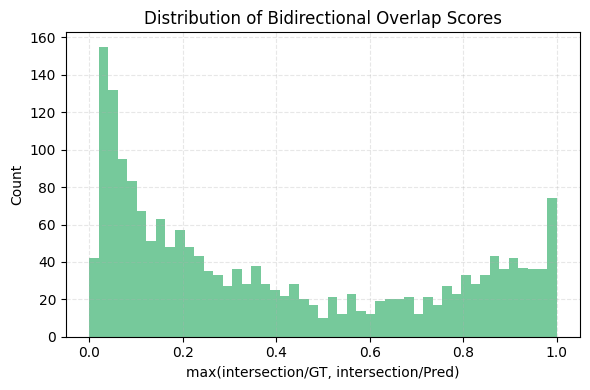

In [28]:
overlap = pairwise_max_overlap(gt_masks, pred_masks)

# For each GT mask: best overlap with any predicted mask
gt_best = overlap.max(axis=1)
pr_best = overlap.max(axis=0)

print(f"Mean max-overlap per GT: {gt_best.mean():.3f}")
print(f"Mean max-overlap per Pred: {pr_best.mean():.3f}")
print(f"Fraction of GT with overlap ≥0.5: {(gt_best>=0.5).mean()*100:.1f}%")
print(f"Fraction of Pred with overlap ≥0.5: {(pr_best>=0.5).mean()*100:.1f}%")

# Visualization of overlap distribution
plt.figure(figsize=(6,4))
plt.hist(overlap[overlap>0].ravel(), bins=np.linspace(0,1,50), color='mediumseagreen', alpha=0.7)
plt.xlabel('max(intersection/GT, intersection/Pred)')
plt.ylabel('Count')
plt.title('Distribution of Bidirectional Overlap Scores')
plt.grid(True, ls='--', alpha=0.3)
plt.tight_layout()
plt.show()


Threshold ≥ 0.20 | TP=594 FP=186 FN=163 | P=0.762 R=0.785 F1=0.773
Threshold ≥ 0.30 | TP=576 FP=204 FN=181 | P=0.738 R=0.761 F1=0.750
Threshold ≥ 0.50 | TP=529 FP=251 FN=228 | P=0.678 R=0.699 F1=0.688
Threshold ≥ 0.70 | TP=463 FP=317 FN=294 | P=0.594 R=0.612 F1=0.602


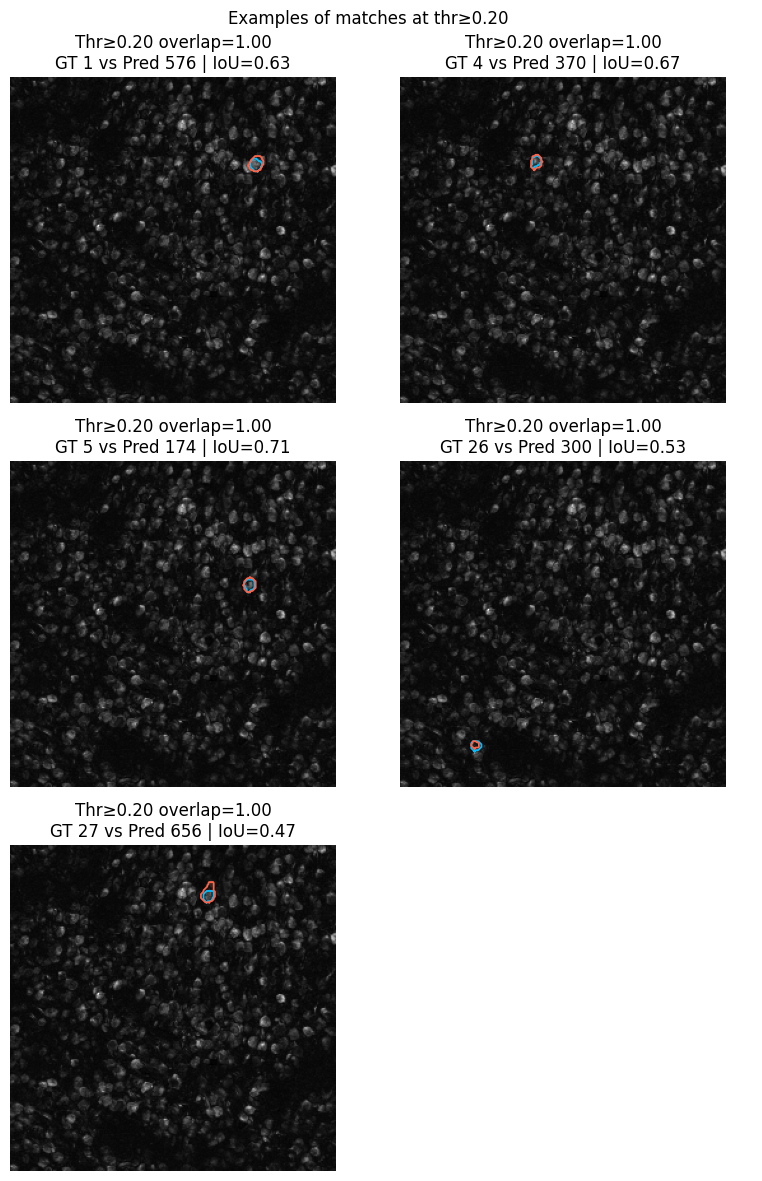

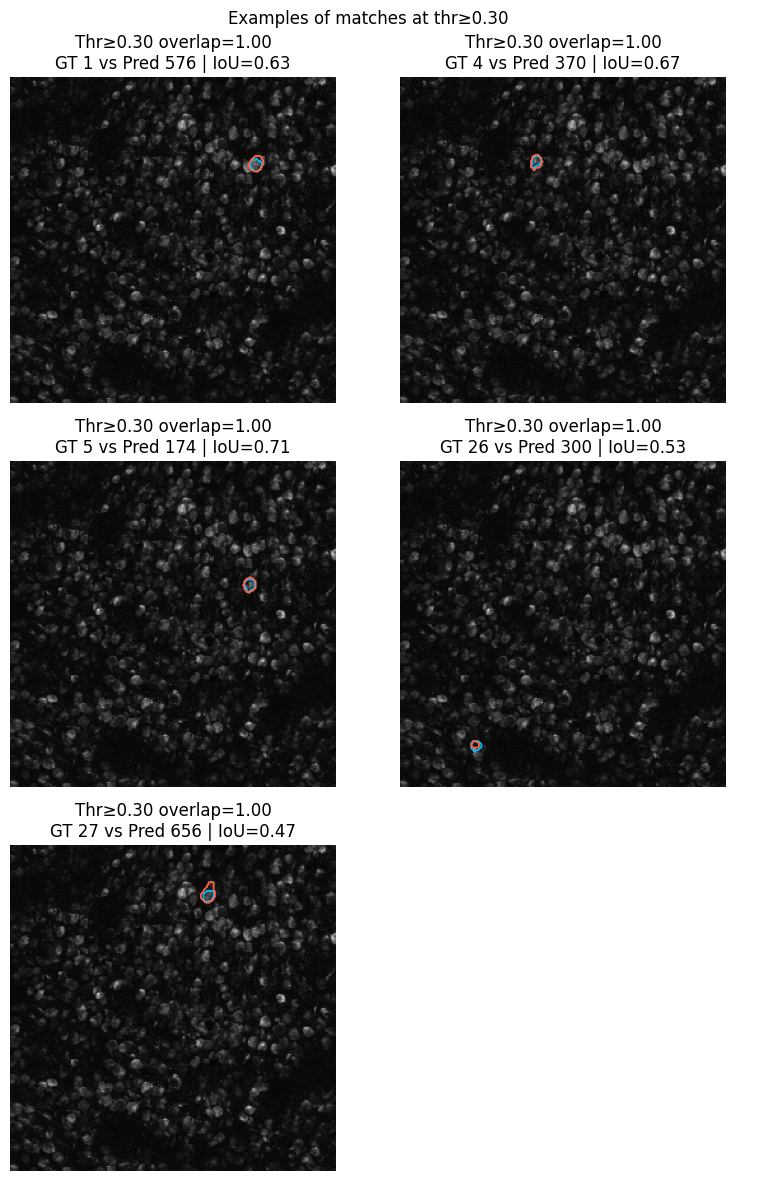

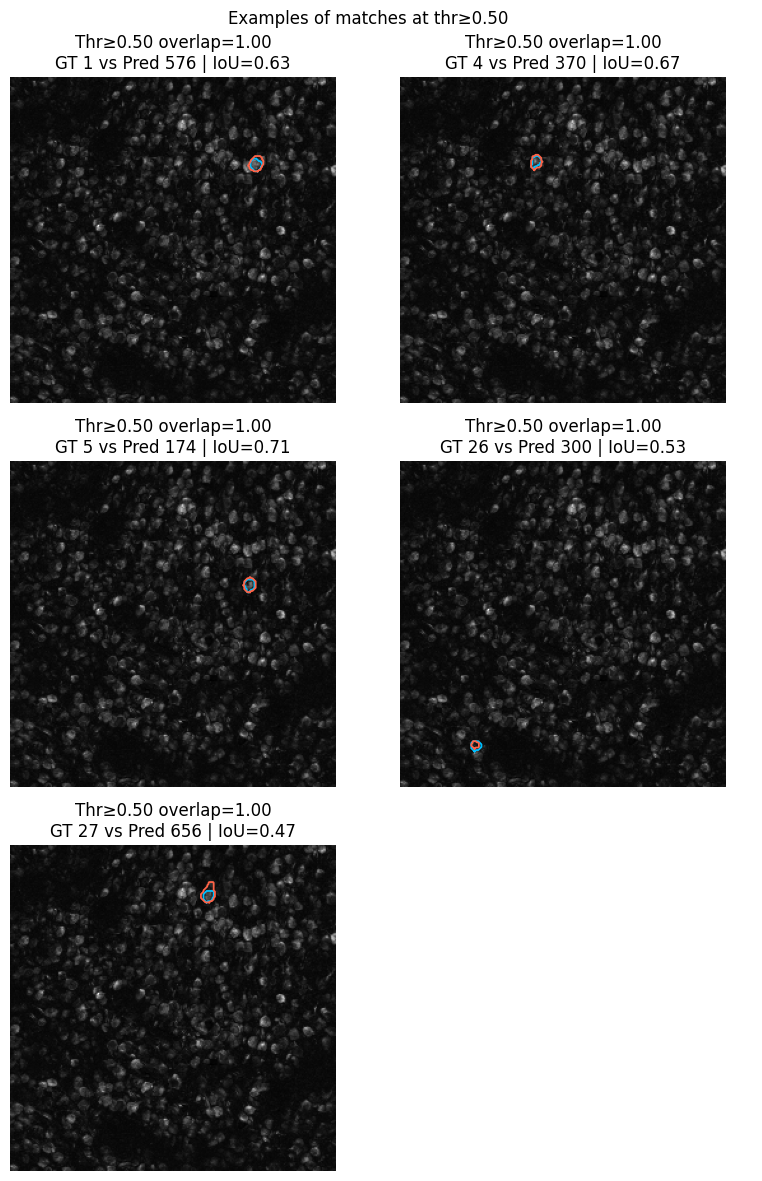

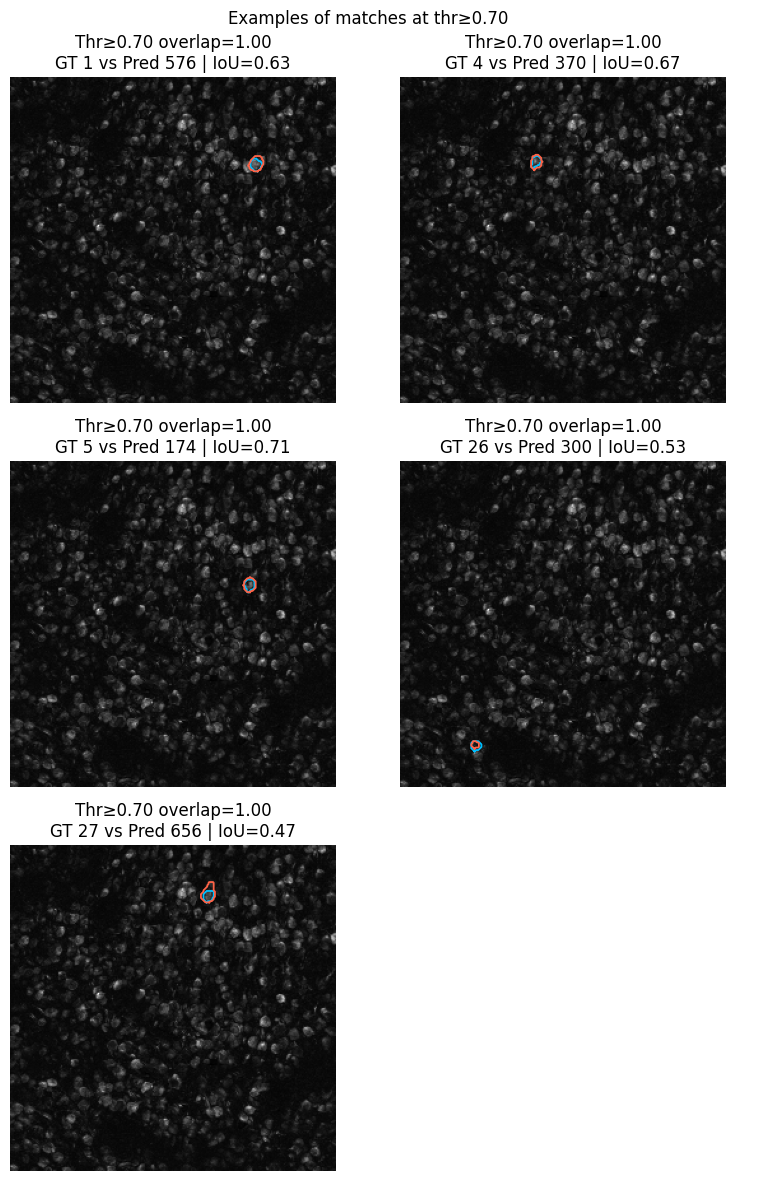

In [30]:
from scipy.optimize import linear_sum_assignment


def compute_f1_from_overlap(overlap_matrix, thr=0.5):
    """
    Computes TP/FP/FN and F1 based on the bidirectional overlap matrix.
    Matching is done via Hungarian assignment using overlap >= thr.
    """
    if overlap_matrix.size == 0:
        return dict(TP=0, FP=0, FN=0, precision=0.0, recall=0.0, f1=0.0)

    N_gt, N_pr = overlap_matrix.shape

    # cost matrix = 1 - overlap (we want to maximize overlap)
    cost = 1.0 - overlap_matrix
    cost[overlap_matrix < thr] = 1e6  # forbid low-overlap pairs

    # Hungarian matching (optimal one-to-one matches)
    row_ind, col_ind = linear_sum_assignment(cost)
    matched = overlap_matrix[row_ind, col_ind] >= thr
    TP = int(matched.sum())
    FP = N_pr - TP
    FN = N_gt - TP

    precision = TP / (TP + FP + 1e-8)
    recall    = TP / (TP + FN + 1e-8)
    f1        = 2 * precision * recall / (precision + recall + 1e-8)

    return dict(TP=TP, FP=FP, FN=FN, precision=precision, recall=recall, f1=f1)


# ---- Try for a few thresholds ----
thr_list = [0.2, 0.3, 0.5, 0.7]
for thr in thr_list:
    res = compute_f1_from_overlap(overlap, thr)
    print(f"Threshold ≥ {thr:.2f} | TP={res['TP']} FP={res['FP']} FN={res['FN']} "
          f"| P={res['precision']:.3f} R={res['recall']:.3f} F1={res['f1']:.3f}")

# ---- Visualize 5 matched examples per threshold ----
for thr in thr_list:
    if overlap.size == 0:
        continue
    cost = 1.0 - overlap
    cost[overlap < thr] = 1e6
    row_ind, col_ind = linear_sum_assignment(cost)

    pairs = [(int(g), int(p), float(overlap[g, p]))
             for g, p in zip(row_ind, col_ind) if overlap[g, p] >= thr]
    if not pairs:
        continue
    pairs.sort(key=lambda x: x[2], reverse=True)
    sel = pairs[:5]
    grid_pairs = [(g, p, f'Thr≥{thr:.2f} overlap={ovv:.2f}') for g, p, ovv in sel]
    _plot_pairs_grid(grid_pairs, f'Examples of matches at thr≥{thr:.2f}')


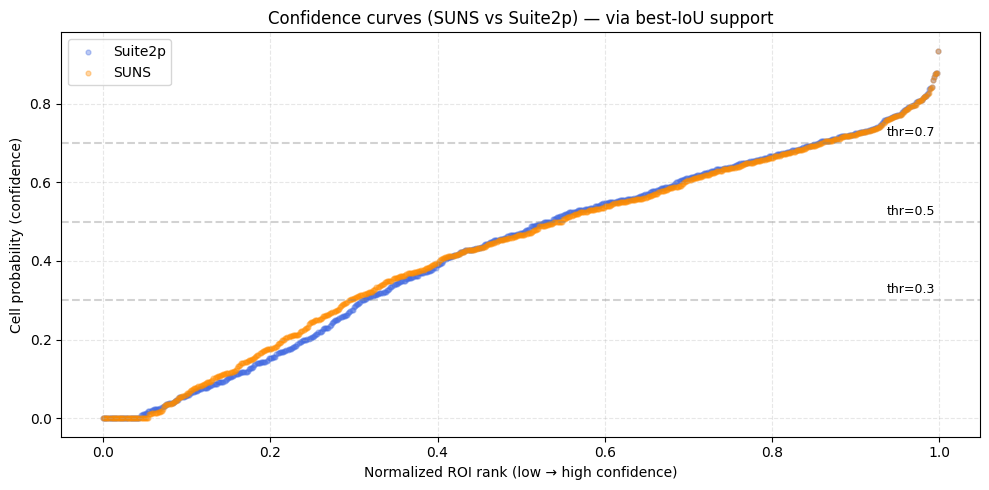

In [31]:
# --- Confidence curves (SUNS vs Suite2p) using masks-only confidences ---
import numpy as np
import matplotlib.pyplot as plt


def plot_confidence_sigmoids(prob_suns, prob_s2p, smooth_window=21, thresholds=(0.3, 0.5, 0.7)):
    """
    Plots confidence-only curves for SUNS and Suite2p.
    X-axis = normalized ROI rank (low→high confidence), Y-axis = cell probability.
    """
    def sort_asc(y):
        return y[np.argsort(y)]

    def smooth(y, w=21):
        if w < 3 or (w % 2 == 0):  # require odd window >=3
            return y
        pad = w // 2
        ypad = np.pad(y, (pad, pad), mode='edge')
        kernel = np.ones(w) / w
        return np.convolve(ypad, kernel, mode='valid')

    # Convert inputs to arrays
    prob_suns = np.asarray(prob_suns, dtype=float)
    prob_s2p  = np.asarray(prob_s2p,  dtype=float)

    # Sort each method by its own confidence (ascending)
    y_suns = sort_asc(prob_suns)
    y_s2p  = sort_asc(prob_s2p)

    # Normalized rank (0..1)
    x_suns = np.linspace(0, 1, len(y_suns), endpoint=False)
    x_s2p  = np.linspace(0, 1, len(y_s2p), endpoint=False)

    # Light smoothing for a sigmoid look (keeps length)
    ys_suns = smooth(y_suns, w=smooth_window)
    ys_s2p  = smooth(y_s2p,  w=smooth_window)

    # ---- Plot
    plt.figure(figsize=(10, 5))
    # ROI points only (no smoothed lines)
    plt.scatter(x_s2p,  y_s2p,  s=12, alpha=0.35, color='royalblue',  label='Suite2p')
    plt.scatter(x_suns, y_suns, s=12, alpha=0.35, color='darkorange', label='SUNS')

    # Optional probability thresholds
    for thr in thresholds:
        plt.axhline(thr, linestyle='--', alpha=0.35, color='gray')
        plt.text(0.995, thr + 0.01, f"thr={thr}", ha='right', va='bottom', fontsize=9)

    plt.xlabel('Normalized ROI rank (low → high confidence)')
    plt.ylabel('Cell probability (confidence)')
    plt.title('Confidence curves (SUNS vs Suite2p) — via best-IoU support')
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Derive confidences from masks only (no Fall.mat): best IoU support
#  - SUNS confidence: for each SUNS predicted ROI, max IoU with any Suite2p GT ROI
#  - Suite2p confidence: for each Suite2p GT ROI, max IoU with any SUNS predicted ROI

def _max_iou_per_row(A, B):
    if A.size == 0:
        return np.array([], dtype=float)
    if B.size == 0:
        return np.zeros(A.shape[0], dtype=float)
    I = pairwise_iou(A.astype(bool), B.astype(bool))
    return (I.max(axis=1) if I.size else np.zeros(A.shape[0], dtype=float)).astype(float)

conf_suns = _max_iou_per_row(pred_masks, gt_masks)  # SUNS supported by GT
conf_s2p  = _max_iou_per_row(gt_masks, pred_masks)  # GT supported by SUNS

# Plot curves
plot_confidence_sigmoids(prob_suns=conf_suns, prob_s2p=conf_s2p, smooth_window=21)
